In [1]:
import nemo
import nemo.collections.asr as nemo_asr

In [3]:
import nemo
import nemo.collections.asr as nemo_asr
from my_model_quartznet import MyModel
import os
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import copy

from omegaconf import DictConfig

from nemo.utils.exp_manager import exp_manager
from nemo.collections.asr.models import EncDecCTCModel

# --- Config Information ---#
try:
    from ruamel.yaml import YAML
except ModuleNotFoundError:
    from ruamel_yaml import YAML
config_path = './configs/quartznet_15x5.yaml'

yaml = YAML(typ='safe')

[NeMo W 2022-05-26 01:00:50 experimental:27] Module <class 'nemo.collections.nlp.data.language_modeling.megatron.megatron_batch_samplers.MegatronPretrainingRandomBatchSampler'> is experimental, not ready for production and is not fully supported. Use at your own risk.


In [4]:
from itertools import zip_longest
from typing import Any, Callable, Dict, List, Optional

from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.utilities import rank_zero_info

class PrintTableMetricsCallback(Callback):
    def __init__(self) -> None:
        self.metrics: List = []

    def on_epoch_end(self, trainer: Trainer, pl_module: LightningModule) -> None:
        metrics_dict = copy.copy(trainer.callback_metrics)
        self.metrics.append(metrics_dict)

In [3]:
res = []
# for corruption_prob in np.arange(0.01, 1, 0.3):
with open(config_path) as f:
    params = yaml.load(f)

callback = PrintTableMetricsCallback()
trainer = pl.Trainer(devices=1,
                     accelerator='gpu',
                     max_epochs=250,
#                          num_nodes=1,
                     check_val_every_n_epoch=5,
                     callbacks=[callback],
#                          accumulate_grad_batches=1,
                     enable_checkpointing=False,
                     logger=False,
#                          precision=32
                    )

exp_manager(trainer, params.get("exp_manager", None))

#     params['model']['train_ds']['manifest_filepath'] = train_manifest
#     params['model']['validation_ds']['manifest_filepath'] = test_manifest
#     params['model']['corruption_prob'] = float(corruption_prob)

first_asr_model = EncDecCTCModel(cfg=DictConfig(params['model']), trainer=trainer)

trainer.fit(first_asr_model)
df = pd.DataFrame(callback.metrics).astype(float)
res.append(df)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[NeMo I 2022-05-21 15:47:20 exp_manager:281] Experiments will be logged at /media/boris/F/NeMo_own_research/transfer_learning/nemo_experiments/QuartzNet15x5/2022-05-21_15-47-20
[NeMo I 2022-05-21 15:47:20 exp_manager:647] TensorboardLogger has been set up


[NeMo W 2022-05-21 15:47:20 nemo_logging:349] /media/boris/F/anaconda3/envs/nemo/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:2302: LightningDeprecationWarning: `Trainer.weights_save_path` has been deprecated in v1.6 and will be removed in v1.8.
      rank_zero_deprecation("`Trainer.weights_save_path` has been deprecated in v1.6 and will be removed in v1.8.")
    
[NeMo W 2022-05-21 15:47:20 exp_manager:881] The checkpoint callback was told to monitor a validation value and trainer's max_steps was set to -1. Please ensure that max_steps will run for at least 5 epochs to ensure that checkpointing will not error out.


[NeMo I 2022-05-21 15:47:20 collections:186] Dataset loaded with 200 files totalling 0.16 hours
[NeMo I 2022-05-21 15:47:20 collections:187] 0 files were filtered totalling 0.00 hours
[NeMo I 2022-05-21 15:47:20 collections:186] Dataset loaded with 130 files totalling 0.10 hours
[NeMo I 2022-05-21 15:47:20 collections:187] 0 files were filtered totalling 0.00 hours


[NeMo W 2022-05-21 15:47:20 ctc_models:423] Could not load dataset as `manifest_filepath` was None. Provided config : {'manifest_filepath': None, 'sample_rate': 22050, 'labels': [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'"], 'batch_size': 32, 'shuffle': False}


[NeMo I 2022-05-21 15:47:20 features:259] PADDING: 16
[NeMo I 2022-05-21 15:47:20 features:276] STFT using torch


[NeMo W 2022-05-21 15:47:20 nemo_logging:349] /media/boris/F/anaconda3/envs/nemo/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:385: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
      rank_zero_deprecation(
    
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[NeMo W 2022-05-21 15:47:22 modelPT:496] The lightning trainer received accelerator: <pytorch_lightning.accelerators.gpu.GPUAccelerator object at 0x7f98e3046bb0>. We recommend to use 'ddp' instead.


[NeMo I 2022-05-21 15:47:22 modelPT:587] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.8, 0.5]
        eps: 1e-08
        grad_averaging: False
        lr: 0.01
        weight_decay: 0.001
    )
[NeMo I 2022-05-21 15:47:22 lr_scheduler:833] Scheduler "<nemo.core.optim.lr_scheduler.CosineAnnealing object at 0x7f98a8806a90>" 
    will be used during training (effective maximum steps = 12500) - 
    Parameters : 
    (warmup_steps: null
    warmup_ratio: null
    min_lr: 0.0
    last_epoch: -1
    max_steps: 12500
    )



  | Name              | Type                              | Params
------------------------------------------------------------------------
0 | preprocessor      | AudioToMelSpectrogramPreprocessor | 0     
1 | encoder           | ConvASREncoder                    | 18.9 M
2 | decoder           | ConvASRDecoder                    | 29.7 K
3 | loss              | CTCLoss                           | 0     
4 | spec_augmentation | SpectrogramAugmentation           | 0     
5 | _wer              | WER                               | 0     
------------------------------------------------------------------------
18.9 M    Trainable params
0         Non-trainable params
18.9 M    Total params
75.698    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

[NeMo W 2022-05-21 15:47:22 nemo_logging:349] /media/boris/F/anaconda3/envs/nemo/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
      rank_zero_warn(
    
[NeMo W 2022-05-21 15:47:23 nemo_logging:349] /media/boris/F/anaconda3/envs/nemo/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
      rank_zero_warn(
    


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 4, global step 250: 'val_wer' reached 1.00000 (best 1.00000), saving model to '/media/boris/F/NeMo_own_research/transfer_learning/nemo_experiments/QuartzNet15x5/2022-05-21_15-47-20/checkpoints/QuartzNet15x5--val_wer=1.0000-epoch=4.ckpt' as top 3
[NeMo W 2022-05-21 15:48:32 nemo_logging:349] /media/boris/F/anaconda3/envs/nemo/lib/python3.9/site-packages/torch/nn/modules/module.py:1385: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
      warnings.warn(
    
[NeMo W 2022-05-21 15:48:32 nemo_logging:349] /media/boris/F/anaconda3/envs/nemo/lib/python3.9/site-packages/torch/nn/modules/module.py:1385: UserWarning: argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Mo

Validation: 0it [00:00, ?it/s]

Epoch 9, global step 500: 'val_wer' reached 0.99224 (best 0.99224), saving model to '/media/boris/F/NeMo_own_research/transfer_learning/nemo_experiments/QuartzNet15x5/2022-05-21_15-47-20/checkpoints/QuartzNet15x5--val_wer=0.9922-epoch=9.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 14, global step 750: 'val_wer' reached 1.00000 (best 0.99224), saving model to '/media/boris/F/NeMo_own_research/transfer_learning/nemo_experiments/QuartzNet15x5/2022-05-21_15-47-20/checkpoints/QuartzNet15x5--val_wer=1.0000-epoch=14.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 19, global step 1000: 'val_wer' reached 0.98706 (best 0.98706), saving model to '/media/boris/F/NeMo_own_research/transfer_learning/nemo_experiments/QuartzNet15x5/2022-05-21_15-47-20/checkpoints/QuartzNet15x5--val_wer=0.9871-epoch=19.ckpt' as top 3
[NeMo W 2022-05-21 15:52:34 nemo_logging:349] /media/boris/F/anaconda3/envs/nemo/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:724: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
      rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
    

KeyboardInterrupt



Text(0, 0.5, 'cer')

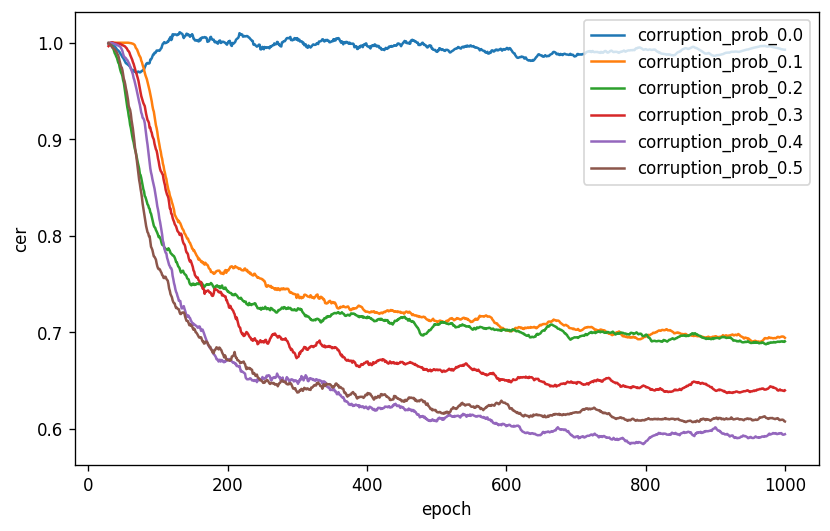

In [19]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt


figure(figsize=(8, 5), dpi=120)

for corruption_prob in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]:
    res = pd.read_csv(f'/media/boris/F/NeMo_own_research/transfer_learning/dataframes/dae_{corruption_prob}')
    res[::2].reset_index()['val_wer'].rolling(30, win_type='gaussian').mean(std=100).plot(label=f'corruption_prob_{corruption_prob}')

plt.legend(loc="upper right")
plt.xlabel('epoch')
plt.ylabel('cer')

In [1]:
from nemo.collections.asr.models import EncDecCTCModel
from nemo.collections.tts.models import FastPitchModel

/media/boris/F/anaconda3/envs/nemo/lib/python3.9/site-packages/apex/pyprof/__init__.py:5: FutureWarning: pyprof will be removed by the end of June, 2022
  warnings.warn("pyprof will be removed by the end of June, 2022", FutureWarning)
################################################################################
### WARNING, path does not exist: KALDI_ROOT=media/boris/F/pykaldi/kaldi
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################

[NeMo W 2022-05-20 15:04:22 experimental:27] Module <class 'nemo.collections.nlp.data.language_modeling.megatron.megatron_batch_samplers.MegatronPretrainingRandomBatchSampler'> is experimental, not ready for production and is not fully supported. Use at your own risk.


In [2]:
import contextlib
from typing import Optional

import torch
from hydra.utils import instantiate
from omegaconf import DictConfig, open_dict
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import LoggerCollection, TensorBoardLogger

from nemo.collections.asr.data.audio_to_text import AudioToCharWithDursF0Dataset
from nemo.collections.common.parts.preprocessing import parsers
from nemo.collections.tts.helpers.helpers import plot_alignment_to_numpy, plot_spectrogram_to_numpy
from nemo.collections.tts.losses.aligner_loss import BinLoss, ForwardSumLoss
from nemo.collections.tts.losses.fastpitchloss import DurationLoss, MelLoss, PitchLoss
from nemo.collections.tts.models.base import SpectrogramGenerator
# from nemo.collections.tts.modules.fastpitch import \
from nemo.collections.tts.torch.tts_data_types import SpeakerID
from nemo.core.classes import Exportable
from nemo.core.classes.common import PretrainedModelInfo, typecheck
from nemo.core.neural_types.elements import (
    Index,
    LengthsType,
    MelSpectrogramType,
    ProbsType,
    RegressionValuesType,
    TokenDurationType,
    TokenIndex,
    TokenLogDurationType,
)
from nemo.core.neural_types.neural_type import NeuralType
from nemo.utils import logging, model_utils

from nemo.core.classes import ModelPT

import nemo
import nemo.collections.asr as nemo_asr
from my_model_quartznet import MyModel
import os
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import copy

In [3]:
import random
import copy
import inspect
import os
import uuid
from abc import abstractmethod
from os import path
from pathlib import Path
from typing import Callable, Dict, List, Optional, Union

import hydra
import torch
from omegaconf import DictConfig, OmegaConf, open_dict
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.utilities import rank_zero_only

from nemo import package_info
from nemo.core import optim
from nemo.core.classes.common import Model
from nemo.core.connectors.save_restore_connector import SaveRestoreConnector
from nemo.core.optim import prepare_lr_scheduler
from nemo.utils import logging, model_utils
from nemo.utils.app_state import AppState
from nemo.utils.get_rank import is_global_rank_zero
from nemo.collections.tts.models import Tacotron2Model


In [4]:
def flip_batch(batch):
    new_batch = torch.clone(batch[0]), torch.clone(batch[1]), torch.clone(batch[2]), torch.clone(batch[3])
    for i in range(len(new_batch)):
        try:
            for j in range(len(new_batch[i])):
                new_batch[i][j] = torch.flip(new_batch[i][j], dims=[0])
        except Exception:
            pass
    return new_batch

In [170]:
class DT_model(ModelPT):
    
    def __init__(self, asr_cfg: DictConfig, tts_cfg: DictConfig, trainer: Trainer = None, *args, **kwargs):
        cfg = OmegaConf.structured({})
        super().__init__(cfg, trainer=kwargs.get('trainer', None))
        self.asr_model = EncDecCTCModel.from_config_dict(asr_cfg)
        self.spec_gen = Tacotron2Model.from_config_dict(tts_cfg)
        
        self._wer = []
        self._other_wer = []
        self.corruption_prob = 0.4
        
        self.asr_model.setup_optimization()
        self.spec_gen.setup_optimization()

    
        self._train_dl = self.spec_gen._train_dl
        self._validation_dl = self.spec_gen._validation_dl
        self._test_dl = self.spec_gen._test_dl
        
        self._optimizer_param_groups = self.asr_model._optimizer_param_groups
        self._optimizer = self.asr_model._optimizer
        self._scheduler = self.asr_model._scheduler
    
    def train_dataloader(self):
#         dataset = OnesDataset(10000)
        return self.spec_gen.train_dataloader()

    def val_dataloader(self):
#         dataset = OnesDataset(10)
        return self.spec_gen.val_dataloader()

    def predict_dataloader(self):
#         dataset = OnesDataset(10)
        return self.spec_gen.predict_dataloader()

    def forward_asr(
        self, input_signal=None, input_signal_length=None, processed_signal=None, processed_signal_length=None,
            dae=False
    ):
        processed_signal, processed_signal_length = self.asr_model.preprocessor(
            input_signal=input_signal, length=input_signal_length,
        )

        ## batch size 16
            
        ## audio corruption marking 8-15 parts of paired data

        encoded, encoded_len = self.asr_model.encoder(audio_signal=processed_signal, length=processed_signal_length)
        
        log_probs = self.asr_model.decoder(encoder_output=encoded)
        greedy_predictions = log_probs.argmax(dim=-1, keepdim=False)

        return log_probs, encoded_len, greedy_predictions

    def forward_spec_gen(self, *, tokens, token_len, audio=None, audio_len=None, dae=False):
        
        if audio is not None and audio_len is not None:
            spec_target, spec_target_len = self.spec_gen.audio_to_melspec_precessor(audio, audio_len)
        token_embedding = self.spec_gen.text_embedding(tokens).transpose(1, 2)
        encoder_embedding = self.spec_gen.encoder(token_embedding=token_embedding, token_len=token_len)
        if self.spec_gen.training:
            spec_pred_dec, gate_pred, alignments = self.spec_gen.decoder(
                memory=encoder_embedding, decoder_inputs=spec_target, memory_lengths=token_len
            )
        else:
            spec_pred_dec, gate_pred, alignments, pred_length = self.spec_gen.decoder(
                memory=encoder_embedding, memory_lengths=token_len
            )
        spec_pred_postnet = self.spec_gen.postnet(mel_spec=spec_pred_dec)

        if not self.spec_gen.calculate_loss:
            return spec_pred_dec, spec_pred_postnet, gate_pred, alignments, pred_length
        return spec_pred_dec, spec_pred_postnet, gate_pred, spec_target, spec_target_len, alignments

    def forward_dt_spec_gen(self, *, signal, signal_len):
        processed_signal, processed_signal_length = self.asr_model.preprocessor(
            input_signal=signal, length=signal_len,
        )

        encoded, encoded_len = self.asr_model.encoder(audio_signal=processed_signal, length=processed_signal_length)

        spec_target, spec_target_len = self.spec_gen.audio_to_melspec_precessor(signal, signal_len)

        spec_pred_dec, gate_pred, alignments = self.spec_gen.decoder(
            memory=encoded.permute(0, 2, 1).cuda(), decoder_inputs=spec_target.cuda(),
                memory_lengths=(torch.ones(encoded.shape[0]) * encoded.shape[2]).long().cuda()
        )

        del signal, signal_len, processed_signal, processed_signal_length, encoded, encoded_len
        
        spec_pred_postnet = self.spec_gen.postnet(mel_spec=spec_pred_dec)

        if not self.spec_gen.calculate_loss:
            return spec_pred_dec, spec_pred_postnet, gate_pred, alignments, pred_length

        return spec_pred_dec, spec_pred_postnet, gate_pred, spec_target, spec_target_len, alignments
    
    def forward_dt_asr(self, *, tokens, token_len):
        token_embedding = self.spec_gen.text_embedding(tokens).transpose(1, 2)
        encoder_embedding = self.spec_gen.encoder(token_embedding=token_embedding, token_len=token_len).permute(0, 2, 1)

        encoded_len = []
        for i in range(encoder_embedding.shape[0]):
            pos = encoder_embedding.shape[2]
            for j in range(len(encoder_embedding[i][0])):
                if encoder_embedding[i][0][j] == 0:
                    pos = j
                    break
            encoded_len.append(pos)
        encoded_len = torch.tensor(encoded_len)

        log_probs = self.asr_model.decoder(encoder_output=encoder_embedding)
        greedy_predictions = log_probs.argmax(dim=-1, keepdim=False)
        
        del tokens, token_len, token_embedding, encoder_embedding
        
        return log_probs, encoded_len, greedy_predictions
    
    def validation_step_asr(self, batch, batch_idx, dataloader_idx=0):
        signal, signal_len, transcript, transcript_len = batch
        
        
        
        transcript = transcript * (transcript < 28)
        
        log_probs, encoded_len, predictions = self.forward_asr(input_signal=signal, input_signal_length=signal_len, dae=False)

        loss_value = self.asr_model.loss(
            log_probs=log_probs, targets=transcript, input_lengths=encoded_len, target_lengths=transcript_len
        )
        self.asr_model._wer.update(
            predictions=predictions, targets=transcript, target_lengths=transcript_len, predictions_lengths=encoded_len
        )
        wer, wer_num, wer_denom = self.asr_model._wer.compute()
        self.asr_model._wer.reset()
        return {
            'val_loss': loss_value,
            'val_wer_num': wer_num,
            'val_wer_denom': wer_denom,
            'val_wer': wer,
        }

    def training_step_asr(self, batch, batch_idx):

        signal, signal_len, transcript, transcript_len = batch
                                                  
        for i in range(signal.shape[0] // 2):
            corruption = np.random.choice([0,1], signal[i].shape[0], p=[self.corruption_prob, 1 - self.corruption_prob])
            signal[i] = signal[i].cpu() * corruption
            signal[i].cuda()
                
        transcript = transcript * (transcript < 28)
        
        log_probs, encoded_len, predictions = self.forward_asr(input_signal=signal, input_signal_length=signal_len)
        
        loss_value = self.asr_model.loss(
            log_probs=log_probs, targets=transcript, input_lengths=encoded_len, target_lengths=transcript_len
        )
        
#         for raw_batch in self.spec_gen.val_dataloader():
#             _, _, tokens, token_len = batch
            
#             log_probs, encoded_len, predictions = self.forward_dt_asr(tokens=tokens, token_len=token_len)
        
#             loss_value += self.asr_model.loss(
#                 log_probs=log_probs, targets=transcript, input_lengths=encoded_len, target_lengths=transcript_len
#             )

#             break
        
#         flipped_batch = flip_batch(batch)
        
#         flipped_signal, flipped_signal_len, flipped_transcript, flipped_transcript_len = flipped_batch
                                                  
#         for i in range(flipped_signal.shape[0] // 2):
#             corruption = np.random.choice([0,1], flipped_signal[i].shape[0], p=[self.corruption_prob, 1 - self.corruption_prob])
#             flipped_signal[i] = flipped_signal[i].cpu() * corruption
#             flipped_signal[i].cuda()
            
#         flipped_transcript = flipped_transcript * (flipped_transcript < 28)
        
#         log_probs, encoded_len, predictions = self.forward_asr(input_signal=flipped_signal,
#                                                                input_signal_length=flipped_signal_len)
        
#         loss_value += self.asr_model.loss(
#             log_probs=log_probs, targets=flipped_transcript, input_lengths=encoded_len, target_lengths=flipped_transcript_len
#         )
        
        tensorboard_logs = {'train_loss': loss_value, 'learning_rate': self.asr_model._optimizer.param_groups[0]['lr']}

        log_every_n_steps = 50

        if (batch_idx + 1) % log_every_n_steps == 0:
            self.asr_model._wer.update(
                predictions=predictions,
                targets=transcript,
                target_lengths=transcript_len,
                predictions_lengths=encoded_len,
            )
            wer, _, _ = self.asr_model._wer.compute()
            self.asr_model._wer.reset()
            tensorboard_logs.update({'training_batch_wer': wer})
            self._other_wer.append(wer)
            
        return {'loss': loss_value} #, 'log': tensorboard_logs}

    def validation_step_spec_gen(self, batch, batch_idx):
        audio, audio_len, tokens, token_len = batch
        spec_pred_dec, spec_pred_postnet, gate_pred, spec_target, spec_target_len, alignments = self.forward_spec_gen(
            audio=audio, audio_len=audio_len, tokens=tokens, token_len=token_len, dae=False
        )

        loss, gate_target = self.spec_gen.loss(
            spec_pred_dec=spec_pred_dec,
            spec_pred_postnet=spec_pred_postnet,
            gate_pred=gate_pred,
            spec_target=spec_target,
            spec_target_len=spec_target_len,
            pad_value=self.spec_gen.pad_value,
        )
        return {
            "val_loss": loss,
            "mel_target": spec_target,
            "mel_postnet": spec_pred_postnet,
            "gate": gate_pred,
            "gate_target": gate_target,
            "alignments": alignments,
        }
    
    def training_step_spec_gen(self, batch, batch_idx):
        audio, audio_len, _tokens, token_len = batch
        
        tokens = torch.clone(_tokens)
        
        for i in range(tokens.shape[0] // 2):
            corruption = np.random.choice([0,1], tokens[i].shape[0], p=[self.corruption_prob, 1 - self.corruption_prob])
            tokens[i] = tokens[i].cpu() * corruption
            tokens[i].cuda()
        
        spec_pred_dec, spec_pred_postnet, gate_pred, spec_target, spec_target_len, _ = self.forward_spec_gen(
            audio=audio, audio_len=audio_len, tokens=tokens, token_len=token_len
        )

        loss, _ = self.spec_gen.loss(
            spec_pred_dec=spec_pred_dec,
            spec_pred_postnet=spec_pred_postnet,
            gate_pred=gate_pred,
            spec_target=spec_target,
            spec_target_len=spec_target_len,
            pad_value=self.spec_gen.pad_value,
        )
        
#         for raw_batch in self.spec_gen.val_dataloader():
            
#             signal, signal_len, _, _ = raw_batch
#             signal, signal_len = signal.cuda(), signal_len.cuda()
            
#             spec_pred_dec, spec_pred_postnet, gate_pred, spec_target, spec_target_len, _ = \
#                 self.forward_dt_spec_gen(signal=signal, signal_len=signal_len)
                
#             loss += self.spec_gen.loss(
#                 spec_pred_dec=spec_pred_dec,
#                 spec_pred_postnet=spec_pred_postnet,
#                 gate_pred=gate_pred,
#                 spec_target=spec_target,
#                 spec_target_len=spec_target_len,
#                 pad_value=self.spec_gen.pad_value,
#             )[0]
                
                
#             del raw_batch
                
#             break
        
#         flipped_batch = flip_batch(batch)
        
#         flipped_audio, flipped_audio_len, flipped__tokens, flipped_token_len = flipped_batch
        
#         flipped_tokens = torch.clone(flipped__tokens)
        
#         for i in range(flipped_tokens.shape[0] // 2):
#             for j in range(flipped_tokens.shape[1]):
#                 if random.random() < self.corruption_prob:
#                     flipped_tokens[i][j] = 0
        
#         spec_pred_dec, spec_pred_postnet, gate_pred, spec_target, spec_target_len, _ = self.forward_spec_gen(
#             audio=flipped_audio, audio_len=flipped_audio_len, tokens=flipped_tokens, token_len=flipped_token_len
#         )

#         loss, _ += self.spec_gen.loss(
#             spec_pred_dec=spec_pred_dec,
#             spec_pred_postnet=spec_pred_postnet,
#             gate_pred=gate_pred,
#             spec_target=spec_target,
#             spec_target_len=spec_target_len,
#             pad_value=self.spec_gen.pad_value,
#         )
                

#         output = {
#             'loss': loss,
#             'progress_bar': {'training_loss': loss},
#             'log': {'loss': loss},
#         }
        return {'loss': loss}
    
    def validation_step(self, batch, batch_idx):
        val_asr = self.validation_step_asr(batch, batch_idx)
        val_spec_gen = self.validation_step_spec_gen(batch, batch_idx)
    
        if batch_idx == 0:
            print('spec_gen val loss', val_spec_gen['val_loss'])
    
        return {k: val_asr.get(k, 0) + val_spec_gen.get(k, 0) for k in set(val_asr) | set(val_spec_gen)}
    
    def training_step(self, batch, batch_idx):
        training_asr = self.training_step_asr(batch, batch_idx)
        training_spec_gen = self.training_step_spec_gen(batch, batch_idx)
    
        if batch_idx == 0:
            print('spec_gen train loss', training_spec_gen['loss'])
    
        return {k: training_asr.get(k, 0) + training_spec_gen.get(k, 0) for k in set(training_asr) | set(training_spec_gen)}
    
    def list_available_models(self):
        pass

    def setup_training_data(self):
        pass

    def setup_validation_data(self):
        pass

    def validation_epoch_end(self, loss):
        
        wer_nums = []
        wer_denoms = []
        
        for test_batch in self.asr_model.val_dataloader():
            test_batch = [x.cuda() for x in test_batch]
            targets = test_batch[2]
            targets_lengths = test_batch[3]        
            log_probs, encoded_len, greedy_predictions = self.asr_model(
                input_signal=test_batch[0], input_signal_length=test_batch[1]
            )
            # Notice the model has a helper object to compute WER
            self.asr_model._wer.update(greedy_predictions, targets, targets_lengths)
            _, wer_num, wer_denom = self.asr_model._wer.compute()
            self.asr_model._wer.reset()
            wer_nums.append(wer_num.detach().cpu().numpy())
            wer_denoms.append(wer_denom.detach().cpu().numpy())

            # Release tensors from GPU memory
            del test_batch, log_probs, targets, targets_lengths, encoded_len, greedy_predictions

        # We need to sum all numerators and denominators first. Then divide.
        print(f"WER = {sum(wer_nums)/sum(wer_denoms)}")
        
        self._wer.append(sum(wer_nums)/sum(wer_denoms))
        
        return self.asr_model.validation_epoch_end(loss)
    
    def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx,
                   optimizer_closure, on_tpu, using_native_amp, using_lbfgs):
        pass
#         self.asr_model._optimizer.step(closure=optimizer_closure)
#         self.spec_gen._optimizer.step(closure=optimizer_closure)

In [171]:

dt_model = DT_model(asr_cfg=DictConfig(params['model']),
                        tts_cfg=DictConfig(config['model']),
                        trainer=trainer)


[NeMo I 2022-05-12 07:51:33 audio_to_text_dataset:41] Model level config does not container `sample_rate`, please explicitly provide `sample_rate` to the dataloaders.
[NeMo I 2022-05-12 07:51:33 audio_to_text_dataset:41] Model level config does not container `labels`, please explicitly provide `labels` to the dataloaders.
[NeMo I 2022-05-12 07:51:33 collections:183] Dataset loaded with 1200 files totalling 0.93 hours
[NeMo I 2022-05-12 07:51:33 collections:184] 0 files were filtered totalling 0.00 hours
[NeMo I 2022-05-12 07:51:33 audio_to_text_dataset:41] Model level config does not container `sample_rate`, please explicitly provide `sample_rate` to the dataloaders.
[NeMo I 2022-05-12 07:51:33 audio_to_text_dataset:41] Model level config does not container `labels`, please explicitly provide `labels` to the dataloaders.
[NeMo I 2022-05-12 07:51:33 collections:183] Dataset loaded with 878 files totalling 0.65 hours
[NeMo I 2022-05-12 07:51:33 collections:184] 0 files were filtered tota

[NeMo E 2022-05-12 07:51:33 tacotron2:288] The train dataloader for Tacotron2Model() has shuffle set to False!!!


[NeMo I 2022-05-12 07:51:33 collections:183] Dataset loaded with 1200 files totalling 0.93 hours
[NeMo I 2022-05-12 07:51:33 collections:184] 0 files were filtered totalling 0.00 hours


[NeMo E 2022-05-12 07:51:33 tacotron2:290] The validation dataloader for Tacotron2Model() has shuffle set to True!!!


[NeMo I 2022-05-12 07:51:34 collections:183] Dataset loaded with 878 files totalling 0.65 hours
[NeMo I 2022-05-12 07:51:34 collections:184] 0 files were filtered totalling 0.00 hours
[NeMo I 2022-05-12 07:51:34 features:259] PADDING: 16
[NeMo I 2022-05-12 07:51:34 features:276] STFT using torch


[NeMo W 2022-05-12 07:51:34 modelPT:475] Trainer wasn't specified in model constructor. Make sure that you really wanted it.


[NeMo I 2022-05-12 07:51:34 modelPT:587] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.8, 0.5]
        eps: 1e-08
        grad_averaging: False
        lr: 0.01
        weight_decay: 0.001
    )


[NeMo W 2022-05-12 07:51:34 lr_scheduler:816] Neither `max_steps` nor `iters_per_batch` were provided to `optim.sched`, cannot compute effective `max_steps` !
    Scheduler will not be instantiated !
[NeMo W 2022-05-12 07:51:34 modelPT:475] Trainer wasn't specified in model constructor. Make sure that you really wanted it.


[NeMo I 2022-05-12 07:51:34 modelPT:587] Optimizer config = Adam (
    Parameter Group 0
        amsgrad: False
        betas: (0.9, 0.999)
        eps: 1e-08
        foreach: None
        lr: 0.001
        maximize: False
        weight_decay: 1e-06
    )


[NeMo W 2022-05-12 07:51:34 lr_scheduler:816] Neither `max_steps` nor `iters_per_batch` were provided to `optim.sched`, cannot compute effective `max_steps` !
    Scheduler will not be instantiated !


In [2]:
trainer = pl.Trainer(devices=1, accelerator='gpu', max_epochs=1000, check_val_every_n_epoch=1)

trainer.fit(dt_model)

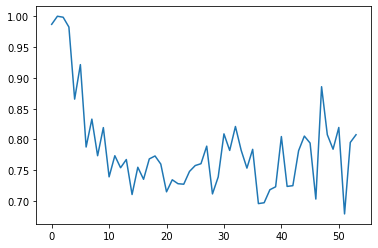

In [44]:
plt.plot(dt_model._wer)